In [123]:
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import SVG

import numpy as np

import pandas as pd

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras_tqdm import TQDMNotebookCallback
from keras.utils import model_to_dot

from sklearn import decomposition
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score, recall_score, precision_score
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

### PCA Data Transformation

In [124]:
def pca_data_transform(X):
    X_out = np.zeros_like(X)
    for i in range(X_out.shape[0]):
        X_sample = X[i]
        X_reshape = X_sample.reshape(-1,X_sample.shape[2])
        pca = decomposition.PCA(n_components=3)
        X_pca = pca.fit_transform(X_reshape)
        X_pca = X_pca.reshape(X_sample.shape)
        X_out[i] = X_pca
    
    return X_out

### Model Definitions and Training

In [125]:
# Dropout and Batchnorm Model
def train_model(X_train, y_train, X_test, y_test, image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size):
    # Create model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=5, input_shape=(image_resize,image_resize,3)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))
    
    model.add(Dropout(dropout))

    model.add(Conv2D(64, kernel_size=4))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))
    
    model.add(Dropout(dropout))

    model.add(Conv2D(128, kernel_size=3))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))
    
    model.add(Dropout(dropout))

    # model.add(Conv2D(256, kernel_size=3, activation='relu'))
    # model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Dropout(dropout))
    model.add(Flatten())
    
    model.add(Dense(fully_connected_nodes))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.add(Dropout(dropout))

    model.add(Dense(Nber_of_breeds, activation='relu'))

    # Compile model
    model_name = "model_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"
    print(model_name)
    
    checkpointer = ModelCheckpoint(filepath="models/" + model_name + ".hdf5", verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    adam = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, early_stopping, TQDMNotebookCallback()], verbose=0)
    
    return model, history

In [126]:
# Optimal model
def train_model(X_train, y_train, X_test, y_test, image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size):
    # Create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(32, kernel_size=5, activation='relu', input_shape=(image_resize,image_resize,3)))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(64, kernel_size=4, activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Conv2D(128, kernel_size=3, activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2,2), padding='same'))

    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(fully_connected_nodes, activation='relu'))
    model.add(Dropout(dropout))

    model.add(Dense(Nber_of_breeds, activation='softmax'))

    # Compile model
    model_name = "model_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"
    print(model_name)
    
    checkpointer = ModelCheckpoint(filepath="models/" + model_name + ".hdf5", verbose=1, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    adam = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[checkpointer, early_stopping, TQDMNotebookCallback()], verbose=0)
    
    return model, history

### Model Evaluation

In [127]:
def evaluate_model(model, X_train, y_train, X_test, y_test, labels_name):
    predictions = model.predict(X_test)
    
    pred_argmax = []
    for pred in predictions:
        pred_argmax.append(pred.argmax())

    true_argmax = []
    for pred in y_test:
        true_argmax.append(pred.argmax())

    accuracy = accuracy_score(true_argmax, pred_argmax)
    conf_matrix = confusion_matrix(true_argmax, pred_argmax)
    
    df = pd.DataFrame(conf_matrix)
    df = df.T
    df.columns = labels_name
    df = df.T
    df.columns = labels_name
    
    y_true = np.array(true_argmax)
    y_scores = np.array(pred_argmax)
    
    precision = precision_score(y_true, y_scores, average='weighted')
    
    recall = recall_score(y_true, y_scores, average='weighted')
    
    return accuracy, recall, precision, df

### Hyperparameters

In [128]:
# Data params
image_resize = 40
Nber_of_breeds = 8
use_pca = False

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rate=0.0005
# learning_rates= [0.0001, 0.0005, 0.001]

# Training params
epochs = 50
batch_size = 20

### Load data

In [129]:
# Load data
X = pickle.load(open("pickles/X_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
y = pickle.load(open("pickles/y_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
labels_name = pickle.load(open("pickles/labels_name_" + str(image_resize) + "x" + str(image_resize) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))

num_validation = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=num_validation)

# PCA
if use_pca:
    X_train = pca_data_transform(X_train)
    X_test = pca_data_transform(X_test)

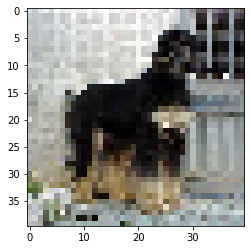

In [130]:
plt.imshow(X_train[7])

### Train Model

model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.05475, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.05475 to 1.88998, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.88998 to 1.80236, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.80236 to 1.77288, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.77288 to 1.71802, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.71802



Epoch 00007: val_loss improved from 1.71802 to 1.68646, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.68646



Epoch 00009: val_loss did not improve from 1.68646



Epoch 00010: val_loss did not improve from 1.68646



Epoch 00011: val_loss did not improve from 1.68646



Epoch 00012: val_loss did not improve from 1.68646
Epoch 00012: early stopping


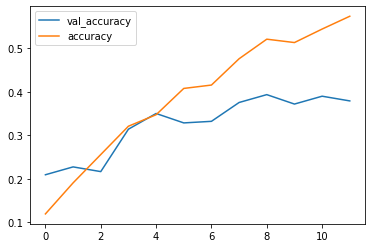

In [131]:
model, history = train_model(X_train, y_train, X_test, y_test, image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)

plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.plot(history.history["accuracy"], label = "accuracy")
plt.legend();

In [77]:
# To train in a loop
# for learning_rate in learning_rates:
#     train_model(image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)

### Evaluate Model

In [120]:
accuracy, recall, precision, conf_matrix = evaluate_model(model, X_train, y_train, X_test, y_test, labels_name)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
conf_matrix

Accuracy: 0.4151624548736462
Recall: 0.4151624548736462
Precision: 0.4193380860348369


,afghan_hound,bernese_mountain_dog,entlebucher,great_pyrenees,maltese_dog,pomeranian,scottish_deerhound,shih-tzu
afghan_hound,10,2,0,6,1,3,8,2
bernese_mountain_dog,5,19,7,1,1,0,3,2
entlebucher,4,12,10,1,1,0,2,5
great_pyrenees,2,1,0,10,8,2,5,2
maltese_dog,1,0,0,3,14,6,2,3
pomeranian,2,2,0,5,3,17,4,3
scottish_deerhound,5,2,2,1,5,2,25,0
shih-tzu,1,2,2,6,7,2,5,10


### K-Fold Cross Validation

In [75]:
n_splits = 5


accuracies = []
recalls = []
precisions = []
conf_matrices = []

# K-Fold cross validation
i = 0
kf = KFold(n_splits=n_splits)
for train, test in kf.split(X, y):
    i += 1
    # Train model
    print("Training split:", i, "of", n_splits)
#     model, history = train_model(X[train], y[train], X[test], y[test], image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)
    model, history = train_model(pca_data_transform(X[train]), y[train], pca_data_transform(X[test]), y[test], image_resize, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)
    
    # Evaluate model
    print("Evaluating split:", i, "of", n_splits)
    accuracy, recall, precision = evaluate_model(model, X[train], y[train], X[test], y[test], labels_name)
    
    # Record metrics
    print("Recording metrics:", i, "of", n_splits)
    accuracies.append(accuracy)
    recalls.append(recall)
    precisions.append(precision)
#     conf_matrices.append(conf_matrix)
    
    print("\n")
    
# Print average metrics
print("Average Mean:", np.asarray(accuracies).mean())
print("Average Recall:", np.asarray(recalls).mean())
print("Average Precision:", np.asarray(precisions).mean())

Training split: 1 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 9.20977, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 9.20977 to 6.44615, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 6.44615 to 5.50050, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss did not improve from 5.50050



Epoch 00005: val_loss did not improve from 5.50050



Epoch 00006: val_loss did not improve from 5.50050



Epoch 00007: val_loss did not improve from 5.50050



Epoch 00008: val_loss did not improve from 5.50050
Epoch 00008: early stopping
Evaluating split: 1 of 5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Recording metrics: 1 of 5


Training split: 2 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 5.36747, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 5.36747 to 5.34259, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss did not improve from 5.34259



Epoch 00004: val_loss did not improve from 5.34259



Epoch 00005: val_loss did not improve from 5.34259



Epoch 00006: val_loss did not improve from 5.34259



Epoch 00007: val_loss did not improve from 5.34259
Epoch 00007: early stopping
Evaluating split: 2 of 5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Recording metrics: 2 of 5


Training split: 3 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 6.57207, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 6.57207 to 4.48007, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 4.48007 to 3.71610, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 3.71610 to 3.67070, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 3.67070 to 3.66861, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss improved from 3.66861 to 3.64183, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss did not improve from 3.64183



Epoch 00008: val_loss did not improve from 3.64183



Epoch 00009: val_loss improved from 3.64183 to 3.38966, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00010: val_loss improved from 3.38966 to 2.68584, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00011: val_loss improved from 2.68584 to 2.53080, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00012: val_loss did not improve from 2.53080



Epoch 00013: val_loss did not improve from 2.53080



Epoch 00014: val_loss improved from 2.53080 to 2.49303, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00015: val_loss did not improve from 2.49303



Epoch 00016: val_loss did not improve from 2.49303



Epoch 00017: val_loss improved from 2.49303 to 2.48130, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00018: val_loss improved from 2.48130 to 2.46419, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00019: val_loss did not improve from 2.46419



Epoch 00020: val_loss did not improve from 2.46419



Epoch 00021: val_loss did not improve from 2.46419



Epoch 00022: val_loss did not improve from 2.46419



Epoch 00023: val_loss did not improve from 2.46419
Epoch 00023: early stopping
Evaluating split: 3 of 5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Recording metrics: 3 of 5


Training split: 4 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 6.10793, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 6.10793 to 2.81479, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss did not improve from 2.81479



Epoch 00004: val_loss improved from 2.81479 to 2.46329, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 2.46329



Epoch 00006: val_loss did not improve from 2.46329



Epoch 00007: val_loss did not improve from 2.46329



Epoch 00008: val_loss did not improve from 2.46329



Epoch 00009: val_loss did not improve from 2.46329
Epoch 00009: early stopping
Evaluating split: 4 of 5


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Recording metrics: 4 of 5


Training split: 5 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 5.47242, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss did not improve from 5.47242



Epoch 00003: val_loss improved from 5.47242 to 3.90814, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 3.90814 to 2.56823, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 2.56823 to 2.41345, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss improved from 2.41345 to 2.33973, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss improved from 2.33973 to 2.33780, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 2.33780



Epoch 00009: val_loss did not improve from 2.33780



Epoch 00010: val_loss did not improve from 2.33780



Epoch 00011: val_loss did not improve from 2.33780



Epoch 00012: val_loss improved from 2.33780 to 2.33738, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00013: val_loss improved from 2.33738 to 2.32823, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00014: val_loss improved from 2.32823 to 2.31171, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00015: val_loss improved from 2.31171 to 2.30321, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00016: val_loss improved from 2.30321 to 2.29605, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00017: val_loss improved from 2.29605 to 2.29566, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00018: val_loss did not improve from 2.29566



Epoch 00019: val_loss did not improve from 2.29566



Epoch 00020: val_loss did not improve from 2.29566



Epoch 00021: val_loss did not improve from 2.29566



Epoch 00022: val_loss did not improve from 2.29566
Epoch 00022: early stopping
Evaluating split: 5 of 5
Recording metrics: 5 of 5


Average Mean: 0.1290716803760282
Average Recall: 0.1290716803760282
Average Precision: 0.028480913656350693


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Compare Models

In [78]:
wout_pca = 0.40457109283196246
w_pca = 0.14421856639247946
w_batchnorm = 0.11919506462984723
w_batchnorm_pca = 0.1290716803760282

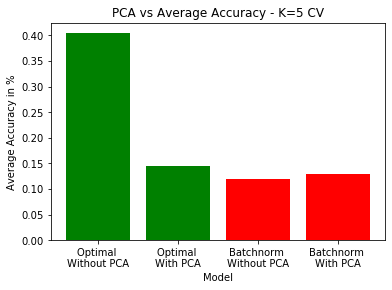

In [95]:
labels = ['Optimal \nWithout PCA', 'Optimal \nWith PCA', 'Batchnorm \nWithout PCA', 'Batchnorm \nWith PCA']
x = ['Optimal Model Without PCA', 'Optimal Model With PCA']

accuracy = [wout_pca, w_pca]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, accuracy, color='green')

x_pos = [i+2 for i, _ in enumerate(x)]
x = ['Batchnorm Model Without PCA', 'Batchnorm Model With PCA']
accuracy = [w_batchnorm, w_batchnorm_pca]
plt.bar(x_pos, accuracy, color='red')

plt.xlabel("Model")
plt.ylabel("Average Accuracy in %")
plt.title("PCA vs Average Accuracy - K=5 CV")

x_pos = [i for i, _ in enumerate(x)]
plt.xticks([0,1,2,3], labels)

plt.show()

### Image Size vs Accuracy - 8 Classes

In [113]:
# Data params
image_resizes = [20, 40, 60, 80]
Nber_of_breeds = 8

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rate=0.0005

# Training params
batch_size = 20

models = []
for size in image_resizes:
    model_name = "model_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

    models.append(model_name)
    print(model_name)

accuracies = []
recalls = []
precisions = []
for size, model_name in zip(image_resizes, models):
    print(f"Training: {size}x{size}")
    # Load data
    X = pickle.load(open("pickles/X_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    y = pickle.load(open("pickles/y_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    labels_name = pickle.load(open("pickles/labels_name_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    
    n_splits = 5


    sample_accuracies = []
    sample_recalls = []
    sample_precisions = []

    # K-Fold cross validation
    i = 0
    kf = KFold(n_splits=n_splits)
    for train, test in kf.split(X, y):
        i += 1
        
        # Load data
        X = pickle.load(open("pickles/X_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
        y = pickle.load(open("pickles/y_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    
        # Train model
        print("Training split:", i, "of", n_splits)
        model, history = train_model(X[train], y[train], X[test], y[test], size, Nber_of_breeds, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)

        # Evaluate model
        print("Evaluating split:", i, "of", n_splits)
        accuracy, recall, precision = evaluate_model(model, X[train], y[train], X[test], y[test], labels_name)

        # Record metrics
        print("Recording metrics:", i, "of", n_splits)
        sample_accuracies.append(accuracy)
        sample_recalls.append(recall)
        sample_precisions.append(precision)

        print("\n")
    
    # Print average metrics
    avg_acc = np.asarray(sample_accuracies).mean()
    print("Average Mean:", avg_acc)
    avg_recall = np.asarray(sample_recalls).mean()
    print("Average Recall:", avg_recall)
    avg_prec = np.asarray(sample_precisions).mean()
    print("Average Precision:", avg_prec)
    
    accuracies.append(avg_acc)
    recalls.append(avg_recall)
    precisions.append(avg_prec)

model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch
model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch
model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch
Training: 20x20
Training split: 1 of 5
model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.06858, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.06858 to 2.01051, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 2.01051 to 1.84055, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.84055 to 1.81315, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 1.81315



Epoch 00006: val_loss improved from 1.81315 to 1.81113, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss improved from 1.81113 to 1.80366, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.80366



Epoch 00009: val_loss did not improve from 1.80366



Epoch 00010: val_loss did not improve from 1.80366



Epoch 00011: val_loss improved from 1.80366 to 1.80296, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00012: val_loss did not improve from 1.80296



Epoch 00013: val_loss did not improve from 1.80296



Epoch 00014: val_loss did not improve from 1.80296



Epoch 00015: val_loss did not improve from 1.80296



Epoch 00016: val_loss did not improve from 1.80296
Epoch 00016: early stopping
Evaluating split: 1 of 5
Recording metrics: 1 of 5


Training split: 2 of 5
model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.07483, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.07483 to 1.98625, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.98625 to 1.81645, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.81645 to 1.80495, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.80495 to 1.72185, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss improved from 1.72185 to 1.63639, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss improved from 1.63639 to 1.57058, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.57058



Epoch 00009: val_loss did not improve from 1.57058



Epoch 00010: val_loss improved from 1.57058 to 1.56990, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00011: val_loss improved from 1.56990 to 1.51326, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00012: val_loss did not improve from 1.51326



Epoch 00013: val_loss did not improve from 1.51326



Epoch 00014: val_loss did not improve from 1.51326



Epoch 00015: val_loss did not improve from 1.51326



Epoch 00016: val_loss did not improve from 1.51326
Epoch 00016: early stopping
Evaluating split: 2 of 5
Recording metrics: 2 of 5


Training split: 3 of 5
model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.07788, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.07788 to 2.02952, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 2.02952 to 1.88208, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss did not improve from 1.88208



Epoch 00005: val_loss improved from 1.88208 to 1.80456, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.80456



Epoch 00007: val_loss did not improve from 1.80456



Epoch 00008: val_loss did not improve from 1.80456



Epoch 00009: val_loss did not improve from 1.80456



Epoch 00010: val_loss improved from 1.80456 to 1.77816, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00011: val_loss improved from 1.77816 to 1.76997, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00012: val_loss did not improve from 1.76997



Epoch 00013: val_loss did not improve from 1.76997



Epoch 00014: val_loss did not improve from 1.76997



Epoch 00015: val_loss did not improve from 1.76997



Epoch 00016: val_loss did not improve from 1.76997
Epoch 00016: early stopping
Evaluating split: 3 of 5
Recording metrics: 3 of 5


Training split: 4 of 5
model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.07448, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.07448 to 2.04677, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 2.04677 to 1.93643, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.93643 to 1.75514, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 1.75514



Epoch 00006: val_loss improved from 1.75514 to 1.70340, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss did not improve from 1.70340



Epoch 00008: val_loss did not improve from 1.70340



Epoch 00009: val_loss improved from 1.70340 to 1.68872, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00010: val_loss did not improve from 1.68872



Epoch 00011: val_loss did not improve from 1.68872



Epoch 00012: val_loss did not improve from 1.68872



Epoch 00013: val_loss did not improve from 1.68872



Epoch 00014: val_loss did not improve from 1.68872
Epoch 00014: early stopping
Evaluating split: 4 of 5
Recording metrics: 4 of 5


Training split: 5 of 5
model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.06967, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.06967 to 1.99277, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.99277 to 1.78889, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.78889 to 1.71996, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 1.71996



Epoch 00006: val_loss did not improve from 1.71996



Epoch 00007: val_loss did not improve from 1.71996



Epoch 00008: val_loss improved from 1.71996 to 1.66790, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00009: val_loss did not improve from 1.66790



Epoch 00010: val_loss improved from 1.66790 to 1.64660, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00011: val_loss improved from 1.64660 to 1.59955, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00012: val_loss did not improve from 1.59955



Epoch 00013: val_loss did not improve from 1.59955



Epoch 00014: val_loss did not improve from 1.59955



Epoch 00015: val_loss did not improve from 1.59955



Epoch 00016: val_loss improved from 1.59955 to 1.59561, saving model to models/model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00017: val_loss did not improve from 1.59561



Epoch 00018: val_loss did not improve from 1.59561



Epoch 00019: val_loss did not improve from 1.59561



Epoch 00020: val_loss did not improve from 1.59561



Epoch 00021: val_loss did not improve from 1.59561
Epoch 00021: early stopping
Evaluating split: 5 of 5
Recording metrics: 5 of 5


Average Mean: 0.32538190364277325
Average Recall: 0.32538190364277325
Average Precision: 0.34817012349915444
Training: 40x40
Training split: 1 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.05328, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.05328 to 1.95806, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.95806 to 1.86868, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.86868 to 1.83912, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 1.83912



Epoch 00006: val_loss improved from 1.83912 to 1.77058, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss improved from 1.77058 to 1.77004, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss improved from 1.77004 to 1.73817, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00009: val_loss did not improve from 1.73817



Epoch 00010: val_loss did not improve from 1.73817



Epoch 00011: val_loss did not improve from 1.73817



Epoch 00012: val_loss did not improve from 1.73817



Epoch 00013: val_loss did not improve from 1.73817
Epoch 00013: early stopping
Evaluating split: 1 of 5
Recording metrics: 1 of 5


Training split: 2 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.05566, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.05566 to 1.91404, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.91404 to 1.75906, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.75906 to 1.68427, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.68427 to 1.54902, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.54902



Epoch 00007: val_loss improved from 1.54902 to 1.49100, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.49100



Epoch 00009: val_loss did not improve from 1.49100



Epoch 00010: val_loss did not improve from 1.49100



Epoch 00011: val_loss did not improve from 1.49100



Epoch 00012: val_loss did not improve from 1.49100
Epoch 00012: early stopping
Evaluating split: 2 of 5
Recording metrics: 2 of 5


Training split: 3 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.06279, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.06279 to 1.85551, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.85551 to 1.84445, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.84445 to 1.83710, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.83710 to 1.75791, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss improved from 1.75791 to 1.72038, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss did not improve from 1.72038



Epoch 00008: val_loss did not improve from 1.72038



Epoch 00009: val_loss improved from 1.72038 to 1.71914, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00010: val_loss did not improve from 1.71914



Epoch 00011: val_loss improved from 1.71914 to 1.56311, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00012: val_loss did not improve from 1.56311



Epoch 00013: val_loss did not improve from 1.56311



Epoch 00014: val_loss did not improve from 1.56311



Epoch 00015: val_loss did not improve from 1.56311



Epoch 00016: val_loss did not improve from 1.56311
Epoch 00016: early stopping
Evaluating split: 3 of 5
Recording metrics: 3 of 5


Training split: 4 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.03791, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.03791 to 2.02914, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 2.02914 to 1.76207, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.76207 to 1.74015, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.74015 to 1.69523, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss improved from 1.69523 to 1.67801, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss improved from 1.67801 to 1.63986, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.63986



Epoch 00009: val_loss did not improve from 1.63986



Epoch 00010: val_loss did not improve from 1.63986



Epoch 00011: val_loss did not improve from 1.63986



Epoch 00012: val_loss improved from 1.63986 to 1.58946, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00013: val_loss did not improve from 1.58946



Epoch 00014: val_loss did not improve from 1.58946



Epoch 00015: val_loss did not improve from 1.58946



Epoch 00016: val_loss did not improve from 1.58946



Epoch 00017: val_loss did not improve from 1.58946
Epoch 00017: early stopping
Evaluating split: 4 of 5
Recording metrics: 4 of 5


Training split: 5 of 5
model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.00716, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.00716 to 1.81591, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.81591 to 1.74008, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.74008 to 1.71063, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.71063 to 1.64298, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss improved from 1.64298 to 1.61626, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss improved from 1.61626 to 1.61404, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.61404



Epoch 00009: val_loss improved from 1.61404 to 1.60330, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00010: val_loss did not improve from 1.60330



Epoch 00011: val_loss improved from 1.60330 to 1.52006, saving model to models/model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00012: val_loss did not improve from 1.52006



Epoch 00013: val_loss did not improve from 1.52006



Epoch 00014: val_loss did not improve from 1.52006



Epoch 00015: val_loss did not improve from 1.52006



Epoch 00016: val_loss did not improve from 1.52006
Epoch 00016: early stopping
Evaluating split: 5 of 5
Recording metrics: 5 of 5


Average Mean: 0.3828613396004701
Average Recall: 0.3828613396004701
Average Precision: 0.39754882758774185
Training: 60x60
Training split: 1 of 5
model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.04610, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.04610 to 1.91345, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.91345 to 1.81496, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.81496 to 1.74128, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 1.74128



Epoch 00006: val_loss did not improve from 1.74128



Epoch 00007: val_loss did not improve from 1.74128



Epoch 00008: val_loss did not improve from 1.74128



Epoch 00009: val_loss did not improve from 1.74128
Epoch 00009: early stopping
Evaluating split: 1 of 5
Recording metrics: 1 of 5


Training split: 2 of 5
model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.00523, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.00523 to 1.87006, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.87006 to 1.58101, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss did not improve from 1.58101



Epoch 00005: val_loss improved from 1.58101 to 1.55165, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss improved from 1.55165 to 1.49740, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss improved from 1.49740 to 1.48140, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss improved from 1.48140 to 1.46502, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00009: val_loss did not improve from 1.46502



Epoch 00010: val_loss did not improve from 1.46502



Epoch 00011: val_loss did not improve from 1.46502



Epoch 00012: val_loss did not improve from 1.46502



Epoch 00013: val_loss did not improve from 1.46502
Epoch 00013: early stopping
Evaluating split: 2 of 5
Recording metrics: 2 of 5


Training split: 3 of 5
model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.04696, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.04696 to 1.88020, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.88020 to 1.73513, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss did not improve from 1.73513



Epoch 00005: val_loss did not improve from 1.73513



Epoch 00006: val_loss did not improve from 1.73513



Epoch 00007: val_loss improved from 1.73513 to 1.70279, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.70279



Epoch 00009: val_loss did not improve from 1.70279



Epoch 00010: val_loss did not improve from 1.70279



Epoch 00011: val_loss did not improve from 1.70279



Epoch 00012: val_loss did not improve from 1.70279
Epoch 00012: early stopping
Evaluating split: 3 of 5
Recording metrics: 3 of 5


Training split: 4 of 5
model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.03780, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.03780 to 1.85847, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.85847 to 1.71212, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.71212 to 1.68228, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.68228 to 1.67090, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss improved from 1.67090 to 1.61888, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00007: val_loss improved from 1.61888 to 1.59245, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.59245



Epoch 00009: val_loss did not improve from 1.59245



Epoch 00010: val_loss did not improve from 1.59245



Epoch 00011: val_loss did not improve from 1.59245



Epoch 00012: val_loss did not improve from 1.59245
Epoch 00012: early stopping
Evaluating split: 4 of 5
Recording metrics: 4 of 5


Training split: 5 of 5
model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.00591, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.00591 to 1.75461, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.75461 to 1.67403, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.67403 to 1.63653, saving model to models/model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 1.63653



Epoch 00006: val_loss did not improve from 1.63653



Epoch 00007: val_loss did not improve from 1.63653



Epoch 00008: val_loss did not improve from 1.63653



Epoch 00009: val_loss did not improve from 1.63653
Epoch 00009: early stopping
Evaluating split: 5 of 5
Recording metrics: 5 of 5


Average Mean: 0.4034958871915393
Average Recall: 0.4034958871915393
Average Precision: 0.4227740301766548
Training: 80x80
Training split: 1 of 5
model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.00182, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.00182 to 1.97993, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.97993 to 1.88763, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss did not improve from 1.88763



Epoch 00005: val_loss improved from 1.88763 to 1.80419, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.80419



Epoch 00007: val_loss did not improve from 1.80419



Epoch 00008: val_loss did not improve from 1.80419



Epoch 00009: val_loss did not improve from 1.80419



Epoch 00010: val_loss did not improve from 1.80419
Epoch 00010: early stopping
Evaluating split: 1 of 5
Recording metrics: 1 of 5


Training split: 2 of 5
model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.01772, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.01772 to 1.80240, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.80240 to 1.57176, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.57176 to 1.56994, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss improved from 1.56994 to 1.48906, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.48906



Epoch 00007: val_loss improved from 1.48906 to 1.48898, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00008: val_loss did not improve from 1.48898



Epoch 00009: val_loss did not improve from 1.48898



Epoch 00010: val_loss did not improve from 1.48898



Epoch 00011: val_loss did not improve from 1.48898



Epoch 00012: val_loss did not improve from 1.48898
Epoch 00012: early stopping
Evaluating split: 2 of 5
Recording metrics: 2 of 5


Training split: 3 of 5
model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 2.09284, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 2.09284 to 1.80632, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.80632 to 1.79692, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.79692 to 1.76525, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 1.76525



Epoch 00006: val_loss did not improve from 1.76525



Epoch 00007: val_loss did not improve from 1.76525



Epoch 00008: val_loss did not improve from 1.76525



Epoch 00009: val_loss did not improve from 1.76525
Epoch 00009: early stopping
Evaluating split: 3 of 5
Recording metrics: 3 of 5


Training split: 4 of 5
model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 1.98504, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 1.98504 to 1.82744, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.82744 to 1.60189, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss improved from 1.60189 to 1.59357, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00005: val_loss did not improve from 1.59357



Epoch 00006: val_loss did not improve from 1.59357



Epoch 00007: val_loss did not improve from 1.59357



Epoch 00008: val_loss did not improve from 1.59357



Epoch 00009: val_loss did not improve from 1.59357
Epoch 00009: early stopping
Evaluating split: 4 of 5
Recording metrics: 4 of 5


Training split: 5 of 5
model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch



Epoch 00001: val_loss improved from inf to 1.99249, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00002: val_loss improved from 1.99249 to 1.72560, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00003: val_loss improved from 1.72560 to 1.61000, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00004: val_loss did not improve from 1.61000



Epoch 00005: val_loss improved from 1.61000 to 1.51642, saving model to models/model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch.hdf5



Epoch 00006: val_loss did not improve from 1.51642



Epoch 00007: val_loss did not improve from 1.51642



Epoch 00008: val_loss did not improve from 1.51642



Epoch 00009: val_loss did not improve from 1.51642



Epoch 00010: val_loss did not improve from 1.51642
Epoch 00010: early stopping
Evaluating split: 5 of 5
Recording metrics: 5 of 5


Average Mean: 0.4067097532314924
Average Recall: 0.4067097532314924
Average Precision: 0.4287376645856321


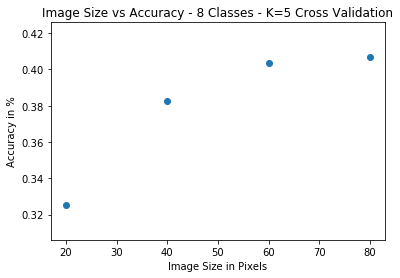

In [114]:
plt.scatter(image_resizes, accuracies);
plt.xlabel("Image Size in Pixels");
plt.ylabel("Accuracy in %");
plt.title(f"Image Size vs Accuracy - {Nber_of_breeds} Classes - K=5 Cross Validation");

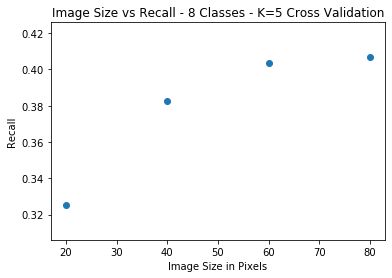

In [117]:
plt.scatter(image_resizes, recalls);
plt.xlabel("Image Size in Pixels");
plt.ylabel("Recall");
plt.title(f"Image Size vs Recall - {Nber_of_breeds} Classes - K=5 Cross Validation");

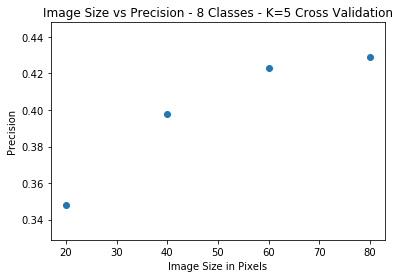

In [118]:
plt.scatter(image_resizes, precisions);
plt.xlabel("Image Size in Pixels");
plt.ylabel("Precision");
plt.title(f"Image Size vs Precision - {Nber_of_breeds} Classes - K=5 Cross Validation");

Loading model: model_20x20_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_40x40_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_80x80_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...


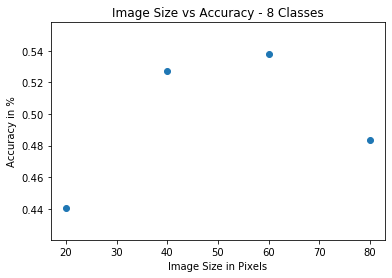

In [53]:
# # Data params
# image_resizes = [20, 40, 60, 80]
# Nber_of_breeds = 8

# # Model params
# dropout = 0.3
# fully_connected_nodes = 500
# learning_rate=0.0005

# # Training params
# batch_size = 20

# models = []
# for size in image_resizes:
#     model_name = "model_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

#     models.append(model_name)

# accuracies = []
# for size, model_name in zip(image_resizes, models):
#     print("Loading model:", model_name)
#     model = load_model('models/' + model_name + '.hdf5')
    
#     print("Loading X_test pickle...")
#     X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    
#     print("Loading y_test pickle...")
#     y_test = pickle.load(open("pickles/y_test_" + str(size) + "x" + str(size) + "_" + str(Nber_of_breeds) + ".pkl", "rb"))
    
#     print("Getting predictions...")
#     predictions = model.predict(X_test)

    
#     pred_argmax = []
#     for pred in predictions:
#         pred_argmax.append(pred.argmax())

#     true_argmax = []
#     for pred in y_test:
#         true_argmax.append(pred.argmax())

#     print("Calculating accuracy...")
#     accuracies.append(accuracy_score(pred_argmax, true_argmax))
    
# plt.scatter(image_resizes, accuracies);
# plt.xlabel("Image Size in Pixels");
# plt.ylabel("Accuracy in %");
# plt.title(f"Image Size vs Accuracy - {Nber_of_breeds} Classes");

### Number of Breeds vs Accuracy - 40x40 Images

In [102]:
# Data params
size = 40
num_breeds = [4, 8, 16, 32, 64]

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rate=0.0005

# Training params
batch_size = 20

models = []
for breed in num_breeds:
    model_name = "model_" + str(size) + "x" + str(size) + "_" + str(breed) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

    models.append(model_name)
print(models)
accuracies = []
recalls = []
precisions = []
for breed, model_name in zip(num_breeds, models):
    print(f"Training: {size}x{size}")
    # Load data
    X = pickle.load(open("pickles/X_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    y = pickle.load(open("pickles/y_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    labels_name = pickle.load(open("pickles/labels_name_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    n_splits = 5


    sample_accuracies = []
    sample_recalls = []
    sample_precisions = []

    # K-Fold cross validation
    i = 0
    kf = KFold(n_splits=n_splits)
    for train, test in kf.split(X, y):
        i += 1
        
        # Load data
        X = pickle.load(open("pickles/X_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
        y = pickle.load(open("pickles/y_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
        # Train model
        print("Training split:", i, "of", n_splits)
        model, history = train_model(X[train], y[train], X[test], y[test], size, breed, dropout, fully_connected_nodes, learning_rate, epochs, batch_size)

        # Evaluate model
        print("Evaluating split:", i, "of", n_splits)
        accuracy, recall, precision = evaluate_model(model, X[train], y[train], X[test], y[test], labels_name)

        # Record metrics
        print("Recording metrics:", i, "of", n_splits)
        sample_accuracies.append(accuracy)
        sample_recalls.append(recall)
        sample_precisions.append(precision)

        print("\n")
    
    # Print average metrics
    avg_acc = np.asarray(sample_accuracies).mean()
    print("Average Accuracy:", avg_acc)
    avg_recall = np.asarray(sample_recalls).mean()
    print("Average Recall:", avg_recall)
    avg_prec = np.asarray(sample_precisions).mean()
    print("Average Precision:", avg_prec)
    
    accuracies.append(avg_acc)
    recalls.append(avg_recall)
    precisions.append(avg_prec)

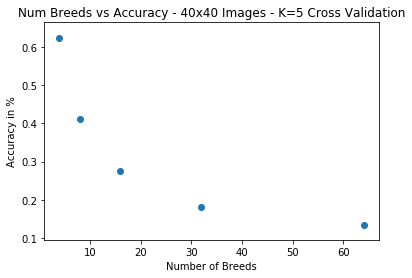

In [107]:
plt.scatter(num_breeds, accuracies);
plt.xlabel("Number of Breeds");
plt.ylabel("Accuracy in %");
plt.title(f"Num Breeds vs Accuracy - {size}x{size} Images - K=5 Cross Validation");

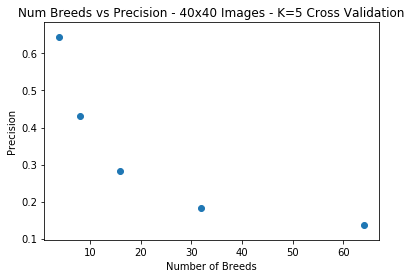

In [109]:
plt.scatter(num_breeds, precisions);
plt.xlabel("Number of Breeds");
plt.ylabel("Precision");
plt.title(f"Num Breeds vs Precision - {size}x{size} Images - K=5 Cross Validation");

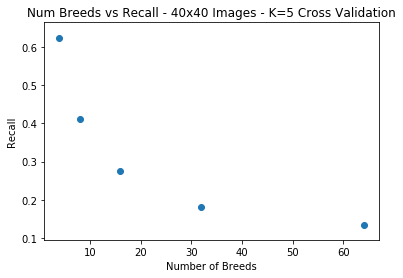

In [111]:
plt.scatter(num_breeds, recalls);
plt.xlabel("Number of Breeds");
plt.ylabel("Recall");
plt.title(f"Num Breeds vs Recall - {size}x{size} Images - K=5 Cross Validation");

Loading model: model_60x60_4breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_16breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_32breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_64breeds_0.3dropout_0.0001lr_500fc_20batch


/home/nschenon/.local/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...


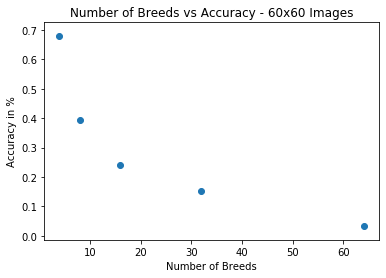

In [11]:
# # Data params
# size = 60
# num_breeds = [4, 8, 16, 32, 64]

# # Model params
# dropout = 0.3
# fully_connected_nodes = 500
# learning_rate=0.0001

# # Training params
# batch_size = 20

# models = []
# for breed in num_breeds:
#     model_name = "model_" + str(size) + "x" + str(size) + "_" + str(breed) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

#     models.append(model_name)

# accuracies = []
# for breed, model_name in zip(num_breeds, models):
#     print("Loading model:", model_name)
#     model = load_model('models/' + model_name + '.hdf5')
    
#     print("Loading X_test pickle...")
#     X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
#     print("Loading y_test pickle...")
#     y_test = pickle.load(open("pickles/y_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
#     print("Getting predictions...")
#     predictions = model.predict(X_test)

    
#     pred_argmax = []
#     for pred in predictions:
#         pred_argmax.append(pred.argmax())

#     true_argmax = []
#     for pred in y_test:
#         true_argmax.append(pred.argmax())

#     print("Calculating accuracy...")
#     accuracies.append(accuracy_score(pred_argmax, true_argmax))
    
# plt.scatter(num_breeds, accuracies);
# plt.xlabel("Number of Breeds");
# plt.ylabel("Accuracy in %");
# plt.title(f"Number of Breeds vs Accuracy - {size}x{size} Images");

### Learning Rate vs Accuracy - 60x60 Images

Loading model: model_60x60_8breeds_0.3dropout_0.0001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.0005lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...
Loading model: model_60x60_8breeds_0.3dropout_0.001lr_500fc_20batch
Loading X_test pickle...
Loading y_test pickle...
Getting predictions...
Calculating accuracy...


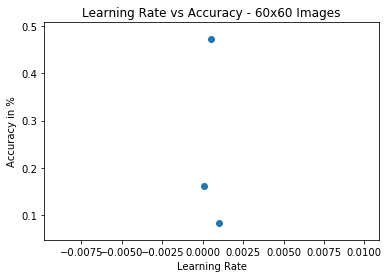

In [12]:
# Data params
size = 60
breed = 8

# Model params
dropout = 0.3
fully_connected_nodes = 500
learning_rates= [0.0001, 0.0005, 0.001]

# Training params
batch_size = 20

models = []
for learning_rate in learning_rates:
    model_name = "model_" + str(size) + "x" + str(size) + "_" + str(breed) + "breeds_" + str(dropout) + "dropout_" + str(learning_rate) + "lr_" + str(fully_connected_nodes) + "fc_" + str(batch_size) + "batch"

    models.append(model_name)

accuracies = []
for breed, model_name in zip(num_breeds, models):
    print("Loading model:", model_name)
    model = load_model('models/' + model_name + '.hdf5')
    
    print("Loading X_test pickle...")
    X_test = pickle.load(open("pickles/X_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    print("Loading y_test pickle...")
    y_test = pickle.load(open("pickles/y_test_" + str(size) + "x" + str(size) + "_" + str(breed) + ".pkl", "rb"))
    
    print("Getting predictions...")
    predictions = model.predict(X_test)

    
    pred_argmax = []
    for pred in predictions:
        pred_argmax.append(pred.argmax())

    true_argmax = []
    for pred in y_test:
        true_argmax.append(pred.argmax())

    print("Calculating accuracy...")
    accuracies.append(accuracy_score(pred_argmax, true_argmax))
    
plt.scatter(learning_rates, accuracies);
plt.xlabel("Learning Rate");
plt.ylabel("Accuracy in %");
plt.title(f"Learning Rate vs Accuracy - {size}x{size} Images");